<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Import-the-Dataset" data-toc-modified-id="Import-the-Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import the Dataset</a></span></li><li><span><a href="#Basic-Observations" data-toc-modified-id="Basic-Observations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Basic Observations</a></span></li><li><span><a href="#Construct-Networks" data-toc-modified-id="Construct-Networks-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Construct Networks</a></span></li></ul></li><li><span><a href="#Community-Structure---Modularity-Maximisation" data-toc-modified-id="Community-Structure---Modularity-Maximisation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Community Structure - Modularity Maximisation</a></span><ul class="toc-item"><li><span><a href="#Primary-Function-from-NetworkX" data-toc-modified-id="Primary-Function-from-NetworkX-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Primary Function from NetworkX</a></span></li><li><span><a href="#Result-Visualisation-through-the-Permutated-Adjacency-Matrix" data-toc-modified-id="Result-Visualisation-through-the-Permutated-Adjacency-Matrix-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Result Visualisation through the Permutated Adjacency Matrix</a></span></li><li><span><a href="#Robustness-Assessment" data-toc-modified-id="Robustness-Assessment-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Robustness Assessment</a></span><ul class="toc-item"><li><span><a href="#Compute-Association-Matrix" data-toc-modified-id="Compute-Association-Matrix-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Compute Association Matrix</a></span></li><li><span><a href="#Compute-NMI-Matrix" data-toc-modified-id="Compute-NMI-Matrix-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Compute NMI Matrix</a></span></li></ul></li><li><span><a href="#Code-Documentation" data-toc-modified-id="Code-Documentation-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Code Documentation</a></span></li></ul></li><li><span><a href="#Questions" data-toc-modified-id="Questions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Questions</a></span></li></ul></div>

In [1]:
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# This will filter warnings, which can be lengthy but sometimes useful. You may comment it out if you want to see them.
import warnings
warnings.filterwarnings('ignore')

This notebook provides coding examples of community detection on a specific dataset that consists of temporal undirected weighted networks. After this class, you should be able to:
- import an empirical network in a more general way, particularly for a temporal one
- perform modularity maximisation for community detection
- visualise relevant results and investigate robustness

# Dataset

**This dataset contains the *temporal network* of contacts between individuals measured in an office building in France, from *June 24 to July 5, 2013*.** This network was described and analysed in the publication [“Data on face-to-face contacts in an office building suggest a low-cost vaccination strategy based on community linkers”](https://www.cambridge.org/core/journals/network-science/article/data-on-facetoface-contacts-in-an-office-building-suggest-a-lowcost-vaccination-strategy-based-on-community-linkers/18AB49AB4F2AEA33CE7501F06ADBC8E8) by M. Génois et al., published as Network Science 3, 326 (2015). The dataset is open available on the [SocioPatterns](http://www.sociopatterns.org/datasets/contacts-in-a-workplace/) website.

**The dataset comprises two files.** The first one contains a tab-separated list representing the active contacts during 20-second intervals of the data collection. Each line has the form “t i j”, where i and j are the anonymous IDs of the persons in contact, and the interval during which this contact was active is [ t – 20s, t ] (t is expressed in seconds since the time origin taken as 0:00 on June 24, 2013). The second file contains a list of the form “i Di” where i is the anonymous ID of an individual and Di the name of his/her department in the workplace. **For simplicity, we will only consider the first file in this class.**

## Import the Dataset

Datasets may not always be documented in a way that enables us to read and construct networks directly using ```nx.read_edgelist``` (as demonstrated in the previous support class). For instance, we need to consider an additional attribute "timestamp" in this dataset. **Therefore, a more general way of processing datasets is employed here.**

*Tip: It is importent to figure out how a dataset is documented (e.g., storage format, network type). Checking the original file of a dataset can be helpful if it can be directly read.*  

In [2]:
data = np.loadtxt('data.dat', dtype='int')

## Basic Observations

As we can see below, this file is organised in **an ascending order of timestamps** (first column). 

In [3]:
data

array([[  28820,     492,     938],
       [  28860,     267,     272],
       [  29300,     181,     826],
       ...,
       [1015440,     150,     601],
       [1016420,     150,     601],
       [1016440,     150,     601]])

In [4]:
np.shape(data)

(9827, 3)

- **Timestamps**

The dataset covers a period of **12 days**, from June 24 to July 5, 2013, and the timestamps in the dataset are **in seconds**. There are a total of **7104 unique timestamps** in the dataset, ranging from 28820 to 1016440, which covers almost the entire 12-day period (as confirmed in the previous description).

In [5]:
time = data[:, 0] # time column

In [6]:
len(set(time)) # the number of timestamps

7104

In [7]:
min(time), max(time) # the range of timestamps

(28820, 1016440)

In [8]:
(1016440 - 28820) / (60*60*24) # check how many days covered

11.430787037037037

- **Individuals**

There are a total of **92 individuals** involved in this dataset, as confirmed in the [second file](http://www.sociopatterns.org/wp-content/uploads/2016/06/metadata_InVS13.txt) of the dataset where the department of each individual is specified. Each individual is represented by a unique ID number, ranging from 15 to 987. 

In [9]:
individuals = np.concatenate((data[:, 1], data[:, 2])) # individuals involved in two columns

In [10]:
len(set(individuals)) # the number of unique individuals

92

In [11]:
min(individuals), max(individuals) # the range of IDs

(15, 987)

- **Contact Links**

The dataset comprises a total of **9827 contact links**, each of which is constructed only if the contact is active during the specified 20-second interval. 

It is important to note that "contact" is an action without direction, therefore each contact link is considered **undirected**. The individual ID in the second column is always prescribed to be smaller than the third column.

It is worth mentioning that in reality, two individuals may remain in continuous contact for a longer duration than 20 seconds. For example, the last two columns in this dataset indicate that individuals 150 and 601 were in contact for (at least) 40 seconds, leading to the construction of two contact links.

In [12]:
np.shape(data)

(9827, 3)

In [13]:
np.all(data[:, 1] < data[:, 2])

True

In [14]:
data[-2:]

array([[1016420,     150,     601],
       [1016440,     150,     601]])

## Construct Networks

There are usually multiple ways to represent a dataset as networks. Intuitively, the original dataset can be described as a single undirected network with multi-edges where each edge is attributed with a timestamp. However, for the purpose of this class, we reorganize the dataset and represent it as **three temporal undirected weighted networks withi no multi-edges**.

We divide the period of this dataset (12 days) into three parts, represented by three temporal networks separately. Each network describes contacts between individuals aggregated in each part (4 days). The weight of each edge indicates how many times a pair of individuals is detected in contact during a 20-second interval and is represented by a positive integer.

1. Divide the dataset into three parts. 

    The dataset appears unbalanced for the second part, potentially because two days during the weekend are included within it (see 2013 calendar [here](https://www.timeanddate.com/calendar/?year=2013&country=9)).

In [15]:
def divide_dataset(data):
    '''
    Input: 
        data: the original dataset (12 days)
    Output: 
        data_list: a list of three partitioned datasets (4 days each)
    '''
    
    data1, data2, data3 = [], [], []
    time_division = [60*60*24 * 4, 60*60*24 * 8]
    
    for contact in data:
        contact = np.array(contact)
        if contact[0] < time_division[0]:
            data1.append(contact)
        elif contact[0] < time_division[1]:
            data2.append(contact)
        else:
            data3.append(contact)
    
    data_list = [np.array(data1), np.array(data2), np.array(data3)]
    
    return data_list

In [16]:
data_list = divide_dataset(data)

In [17]:
len(data_list[0]), len(data_list[1]), len(data_list[2])

(3994, 1647, 4186)

2. For each partitioned dataset, reorganise every edge into the form of tuple: "(ID1, ID2, weight)".

In [18]:
from collections import Counter

def process_dataset(data_list):
    '''
    Input: 
        data_list: a list of three partitioned datasets
    Output: 
        data_tuple: a list of three preprocessed datasets in the form of tuple: (ID1, ID2, weight). 
    '''
    
    data_tuple = []
    
    for data_p in data_list:
        pairs = list(zip(data_p[:, 1],data_p[:, 2])) # create a list of pairs: (ID1, ID2) to represent each contact
        dict_pairs = dict(Counter(pairs)) # count the occurance of each pair; in the form of dictionary: "(ID1, ID2): count"
        tuple_pairs = [(k[0], k[1], dict_pairs[k]) for k in dict_pairs.keys()] # reorganise into tuples
        
        data_tuple.append(tuple_pairs)
    
    return data_tuple

In [19]:
data_tuple = process_dataset(data_list)

In [20]:
data_tuple[0]

[(492, 938, 1),
 (267, 272, 1),
 (181, 826, 1),
 (79, 181, 1),
 (150, 196, 1),
 (21, 150, 4),
 (21, 205, 2),
 (448, 826, 1),
 (765, 826, 1),
 (39, 253, 1),
 (80, 253, 1),
 (123, 845, 13),
 (118, 311, 6),
 (95, 118, 6),
 (80, 95, 1),
 (95, 311, 92),
 (80, 118, 1),
 (118, 771, 2),
 (95, 771, 3),
 (311, 771, 2),
 (153, 205, 1),
 (164, 311, 1),
 (21, 179, 2),
 (311, 481, 1),
 (79, 122, 1),
 (39, 120, 22),
 (122, 448, 4),
 (120, 819, 29),
 (431, 778, 4),
 (271, 601, 45),
 (15, 95, 45),
 (56, 194, 4),
 (194, 786, 11),
 (194, 311, 27),
 (311, 786, 6),
 (95, 205, 4),
 (21, 603, 1),
 (205, 311, 7),
 (95, 123, 70),
 (150, 271, 20),
 (311, 496, 57),
 (21, 431, 1),
 (79, 275, 1),
 (222, 267, 72),
 (50, 179, 1),
 (150, 601, 2),
 (120, 172, 20),
 (271, 448, 1),
 (29, 271, 1),
 (120, 223, 1),
 (116, 123, 1),
 (29, 95, 14),
 (123, 253, 71),
 (79, 253, 1),
 (285, 762, 7),
 (150, 762, 5),
 (29, 79, 1),
 (116, 826, 1),
 (63, 481, 172),
 (762, 771, 15),
 (56, 939, 9),
 (50, 335, 4),
 (778, 826, 3),
 (223,

3. Create three undirected weighted networks with no multi-edges.

In [21]:
def get_network(data_tuple):
    '''
    Input: 
        data_tuple: a list of three preprocessed datasets in the form of tuple: (ID1, ID2, weight).
    Output: 
        G_list: a list of three undirected weighted networks.
    '''
    
    G_list = []
    
    for data_tuple_p in data_tuple:
        G_p = nx.Graph()
        G_p.add_nodes_from(set(individuals)) # Each individual is represented as a node in a graph
        G_p.add_weighted_edges_from(data_tuple_p)
        
        G_list.append(G_p)
    
    return G_list

In [22]:
G_list = get_network(data_tuple)
G1, G2, G3 = G_list

In [23]:
text = ['G1: ', 'G2: ', 'G3: ']
for i in range(3):
    G = G_list[i]
    print(text[i], nx.info(G), '  total number of contact links (weight sum):', np.sum(list(nx.get_edge_attributes(G, 'weight').values())))

G1:  Graph with 92 nodes and 476 edges   total number of contact links (weight sum): 3994
G2:  Graph with 92 nodes and 217 edges   total number of contact links (weight sum): 1647
G3:  Graph with 92 nodes and 389 edges   total number of contact links (weight sum): 4186


# Community Structure - Modularity Maximisation

Here we employ **modularity maximisation via Louvain algorithm** to detect community structures, focusing solely on graph **G1** as an example. Although G1 is an undirected and weighted graph, **our method applies to both directed and undirected graphs, regardless of weight.**

## Primary Function from NetworkX

The primary function for this particular community detection method is readily accessible within NetworkX, and comprehensive details are thoroughly documented [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html). 

In short, there are $5$ variables that can be controlled, with graph G being the required input, and the remaining variables being optional with default values. 
```python
nx_comm.louvain_communities(G, weight = 'weight', resolution = 1, threshold = 1e-07, seed = None)
```

Assuming successful execution, this function will yield a list of sets, each of which comprises nodes belonging to the same community. It should be noted that 
- **Permutation**: the "set" data structure does not allow permutations, and the order of sets in the list is randomized through a shuffle process.
- **Stochasticity**: This method involves stochasticity, where each possible outcome (may or may not be distinct) is associated with a specific seed value. If the input does not include a seed value, the resulting output will exhibit some degree of randomness.

In [24]:
import networkx.algorithms.community as nx_comm
G1_comm = nx_comm.louvain_communities(G1)
G1_comm

[{17, 21, 48, 50, 66, 101, 102, 179, 209, 285, 335, 762, 771, 875},
 {87},
 {119, 122, 150, 153, 154, 271, 448, 492, 499, 533, 601},
 {105, 113, 242, 513},
 {213},
 {743},
 {255},
 {80, 164, 222, 267, 272, 603, 765, 786},
 {35,
  118,
  131,
  134,
  184,
  185,
  210,
  211,
  240,
  265,
  268,
  273,
  275,
  431,
  511,
  751,
  778,
  784,
  804,
  826,
  845,
  938},
 {791},
 {63, 116, 481, 709},
 {15,
  29,
  39,
  56,
  79,
  95,
  120,
  123,
  132,
  172,
  181,
  194,
  196,
  205,
  223,
  253,
  311,
  494,
  496,
  662,
  779,
  819,
  939,
  987}]

## Result Visualisation through the Permutated Adjacency Matrix

To enhance the interpretability of the community detection results, we rearrange the nodes of graph G1 to form clusters of nodes within the same community. The order of these clusters is determined based on their size, with larger clusters appearing first in the sequence. We then construct the corresponding adjacency matrix and present it visually.

1. **Generate a new graph** that maintains the coherence of the input graph G, wherein nodes are rearranged to represent clusters of nodes within the corresponding community. The clusters are organized in descending order based on their size.

In [25]:
def rearrange_graph(G, comm):
    '''
    Input: 
        G: (un)directed (un)weighted graph
        comm: a list of sets, each of which comprises nodes belonging to the same community
    Output: 
        G_perm: it maintains the coherence of the input graph G, wherein nodes are rearranged to represent clusters of nodes within the corresponding community
    '''
    # Initialise an empty new graph with the same type as G
    G_perm = G.copy(); G_perm.clear() 
    
    # Arrange the sets in the comm list in a descending order based on the size of each set
    comm_copy = comm.copy(); # retain the input "comm"
    comm_copy.sort(key=len, reverse = True) 
    
    # Add nodes
    for comm_set in comm_copy:
        G_perm.add_nodes_from(list(comm_set))
    
    # Add edges
    for edge in G.edges.data():
        G_perm.add_edges_from([edge])
        
    return G_perm

In [26]:
G_perm = rearrange_graph(G1, G1_comm)

In [27]:
G_perm.nodes

NodeView((194, 196, 132, 779, 205, 15, 79, 662, 987, 120, 29, 95, 223, 39, 939, 172, 494, 496, 819, 181, 311, 56, 123, 253, 131, 134, 265, 778, 268, 845, 784, 273, 210, 275, 211, 35, 804, 938, 431, 751, 240, 118, 184, 185, 826, 511, 66, 771, 101, 102, 875, 335, 48, 209, 17, 179, 50, 21, 762, 285, 448, 122, 492, 271, 601, 499, 533, 150, 119, 153, 154, 164, 267, 272, 80, 786, 603, 765, 222, 513, 242, 105, 113, 481, 116, 709, 63, 87, 213, 743, 255, 791))

2. **Compute permuted adjacency matrix**: We have further designed a function that returns the permuted adjacency matrix directly for ease of use.

In [28]:
def compute_perm_adj(G, comm):
    '''
    Input:
        G: (un)directed (un)weighted graph
        comm: a list of sets, each of which comprises nodes belonging to the same community
    Output:
        A_perm: permuted adjacency matrix
    '''
    G_perm = rearrange_graph(G, comm)
    A_perm = nx.adjacency_matrix(G_perm).todense()
    
    return A_perm

In [29]:
A_perm = compute_perm_adj(G1, G1_comm)

In [30]:
A_perm

matrix([[ 0,  0, 14, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [14,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]])

3. **Visualisation**
    - **Parameters**: There are a multitude of parameters that can be customized when plotting results, such as the title, font size and colormap. We encourage you to conduct some explorations on your own to become familiar with these options.

    - **Log Transformation**: It should be noted that in the case of graph G1, the adjacency matrix not only represents the existence of edges but also the weight of each edge. As can be observed below, the range of weights is relatively large, making visualization through the normal scale of the colorbar difficult. Therefore, a log transformation is applied to the weight.
    
    - **"LogNorm" vs "SymLogNorm"**: Take a look at the distinction between "LogNorm" and "SymLogNorm" and try to understand why "SymLogNorm" is chosen in this particular case.

In [31]:
import seaborn as sns
from matplotlib.colors import LogNorm, SymLogNorm

In [32]:
A = nx.adjacency_matrix(G1).todense() # We also get the original adjacency matrix of G1 for comparison

Text(0.5, 1.0, 'Permutated Adjacency Matrix - LogTranform')

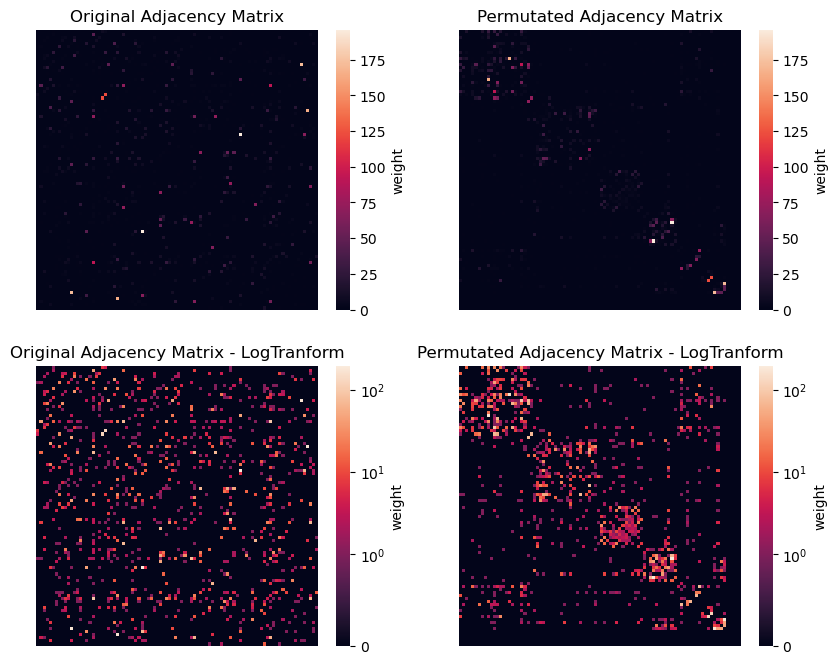

In [33]:
fig, axes = plt.subplots(2, 2, figsize = (10, 8))

sns.heatmap(A, xticklabels = 0, yticklabels = 0, ax = axes[0,0], cbar_kws={'label': 'weight'})
axes[0, 0].set_title('Original Adjacency Matrix')

sns.heatmap(A_perm, xticklabels = 0, yticklabels = 0, ax = axes[0,1], cbar_kws={'label': 'weight'})
axes[0, 1].set_title('Permutated Adjacency Matrix')

sns.heatmap(A, xticklabels = 0, yticklabels = 0, ax = axes[1,0], norm = SymLogNorm(1), cbar_kws={'label': 'weight'})
axes[1, 0].set_title('Original Adjacency Matrix - LogTranform')

sns.heatmap(A_perm, xticklabels = 0, yticklabels = 0, ax = axes[1,1], norm = SymLogNorm(1), cbar_kws={'label': 'weight'})
axes[1, 1].set_title('Permutated Adjacency Matrix - LogTranform')

## Robustness Assessment 

Recall that this community detection method involves stochasticity, where each possible outcome (may or may not be distinct) is associated with a specific seed value. We will run community detection using different seed values and examine the similarity of each generated partition.

### Compute Association Matrix

An association matrix is utilized to visualize the stochasticity of community detection.

- **Each entry in the matrix** indicates the proportion of times two nodes are assigned to the same community across a specified number of community detection runs. The matrix's diagonal values are always assigned a value of 1.
- **Nodes are rearranged** in accordance with the input community detection result, forming clusters of nodes within the same community. As per usual, the order of these clusters is determined based on their size, with larger clusters appearing first in the sequence.

1. Compute an association matrix in a single run, where each entry is either 1 or 0. A value of 1 signifies that two nodes belong to the same community, while 0 denotes that they do not. As usual, the diagonal values of the matrix are always assigned a value of 1.

In [34]:
def compute_asso_one_run(G, perm_comm, seed):
    '''
    We create an unweighted dummy graph. An edge is generated if two nodes are assigned to the same community when performing community detection in graph G. 
    
    Input:
        G: (un)directed (un)weighted graph
        perm_comm: a list of sets, each of which comprises nodes belonging to the same community
        seed: random seed
    Output:
        A_dummy: a matrix indicates whether two nodes are assigned to the same community
    '''
    
    # community detection results
    G_comm = nx_comm.louvain_communities(G, seed = seed) 
    # get a graph with permuted nodes but no edges
    G_dummy = rearrange_graph(G, perm_comm); G_dummy.remove_edges_from(list(G_dummy.edges))
    
    for comm in G_comm:
        comm = list(comm)
        G_dummy_edges = [(a, b) for idx, a in enumerate(comm) for b in comm[idx + 0:]]
        G_dummy.add_edges_from(G_dummy_edges)
    A_dummy = nx.adjacency_matrix(G_dummy).todense()
    
    return A_dummy

2. Aggregate all association matrices in a single run and then divide the resulting matrix by the number of runs.

In [35]:
def compute_asso(G, comm, n_runs, perm = True):
    '''
    Input:
        G: (un)directed (un)weighted graph
        comm: a list of sets, each of which comprises nodes belonging to the same community
        n_runs: the number of community detection runs
        perm: whether to permute association matrix according to comm
    Output:
        A_asso: a matrix indicates the proportion of times two nodes are assigned to the same community
    '''
    
    A_asso = np.zeros((len(G.nodes), len(G.nodes)))
    
    if perm:
        for i in range(n_runs):
            A_asso += compute_asso_one_run(G, comm, i)
    else:
        for i in range(n_runs):
            A_asso += compute_asso_one_run(G, [set(G.nodes)], i)
    A_asso /= n_runs
    
    return A_asso

In [36]:
n_runs = 100
A_asso = compute_asso(G1, G1_comm, n_runs = n_runs, perm = False)
A_perm_asso = compute_asso(G1, G1_comm, n_runs = n_runs)

Text(0.5, 1.0, 'Permutated Association Matrix')

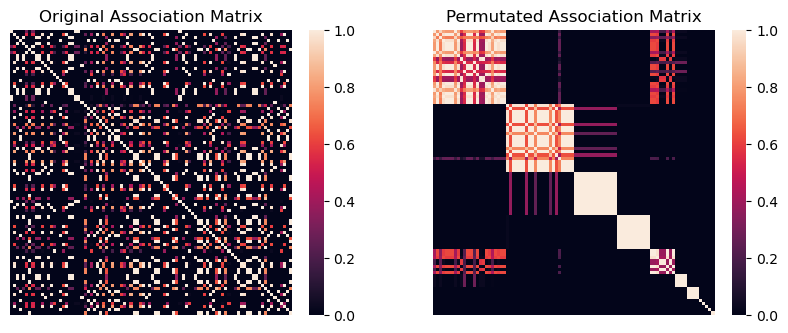

In [37]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3.7))

sns.heatmap(A_asso, xticklabels = 0, yticklabels = 0, ax = axes[0])
axes[0].set_title('Original Association Matrix')

sns.heatmap(A_perm_asso, xticklabels = 0, yticklabels = 0, ax = axes[1])
axes[1].set_title('Permutated Association Matrix')

### Compute NMI Matrix

Here we check the similarity between different partitions using the normalized Mutual Information (nMI). See code documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html).

Note that one could consider several measures of partition similarity. Further details on similarity measures to compare partitions can be found in: [M. Meila. Comparing clusterings | an information based distance. Journal of Multivariate Analysis, 98(5):873--895, 2007.](https://www.sciencedirect.com/science/article/pii/S0047259X06002016)

1. For each community detection, convert the partition result into a dictionary format of {node: label}, where each label is an integer, and nodes with the same label are assigned to the same community. The magnitude of the label is not significant; rather, what matters is whether nodes are assigned different labels or not.

In [38]:
def comm_detection_dict(G, seed):
    '''
    Input:
        G: (un)directed (un)weighted graph
        n_runs: the number of community detection runs
    Output:
        G_comm_dict: a dictionary format of {node: label}, where each label is an integer, and nodes with the same label are assigned to the same community.
    '''
    
    G_comm = nx_comm.louvain_communities(G, seed = seed)
    G_comm_dict = {node: 0 for node in G.nodes}
    
    index = 0
    for comm in G_comm:
        for node in comm:
            G_comm_dict[node] = index
        index += 1
        
    return G_comm_dict

2. Using the normalized Mutual Information (nMI) metric, calculate the level of dissimilarity between each pair of partition results.

In [39]:
import sklearn
from sklearn import metrics

def compute_nMI(G, n_runs):
    '''
    Input:
        G: (un)directed (un)weighted graph
        n_runs: the number of community detection runs
    Output:
        nMI_matrix: a matrix indicates the similarity between different partitions
    '''
    
    # Obtain community results using different random seeds. Convert results to labels and save them in a numpy array.
    n_runs_labels = []
    for i in range(n_runs):
        label = np.array(list(comm_detection_dict(G, seed = i).values()))
        n_runs_labels.append(label)
    n_runs_labels = np.array(n_runs_labels)
    
    # Calculate the level of dissimilarity between each pair of partition results using NMI
    nMI_matrix = np.zeros((n_runs, n_runs))
    for i in range(n_runs):
        for j in range(n_runs):
            nMI_matrix[i, j] = sklearn.metrics.normalized_mutual_info_score(n_runs_labels[i], n_runs_labels[j])
    
    return nMI_matrix

In [40]:
nMI_matrix = compute_nMI(G1, n_runs = 100)

Text(0.5, 1.0, 'nMI matrix')

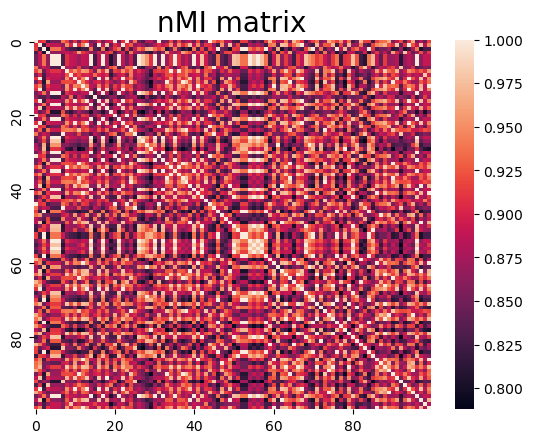

In [48]:
sns.heatmap(nMI_matrix, xticklabels = 20, yticklabels = 20)
plt.title('nMI matrix', fontsize = 20)

## Code Documentation

Ensure that the code is well-documented so that it will be easier for you to generate community detection results.

You can refer to the [Modularity_Maximisation.py](Modularity_Maximisation.py) file which includes all the functions above for community detection using the Modularity Maximisation via the Louvain Algorithm. This file also enables additional parameters such as 'weight', 'resolution', 'threshold', and 'seed'. For instance, the "resolution" parameter has been reset to 0.5 (default value is 1) in this example.

In [42]:
import Modularity_Maximisation as MM

In [43]:
A2, A_perm2, A_asso2, A_perm_asso2, nMI_matrix2 = MM.aggregated_results(G1, n_runs = 100, resolution = 0.5)

Text(0.5, 1.0, 'Permutated Adjacency Matrix - LogTranform')

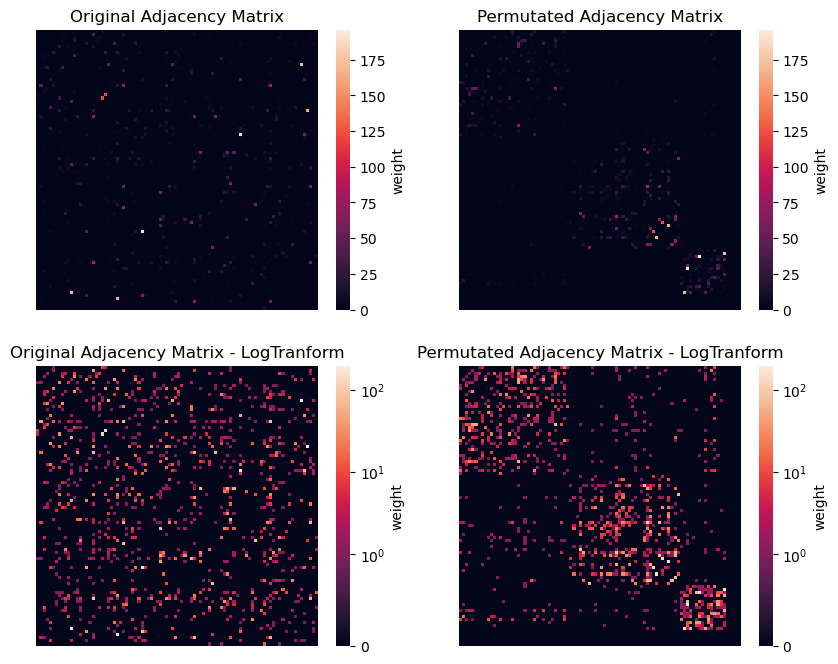

In [44]:
fig, axes = plt.subplots(2, 2, figsize = (10, 8))

sns.heatmap(A2, xticklabels = 0, yticklabels = 0, ax = axes[0,0], cbar_kws={'label': 'weight'})
axes[0, 0].set_title('Original Adjacency Matrix')

sns.heatmap(A_perm2, xticklabels = 0, yticklabels = 0, ax = axes[0,1], cbar_kws={'label': 'weight'})
axes[0, 1].set_title('Permutated Adjacency Matrix')

sns.heatmap(A2, xticklabels = 0, yticklabels = 0, ax = axes[1,0], norm = SymLogNorm(1), cbar_kws={'label': 'weight'})
axes[1, 0].set_title('Original Adjacency Matrix - LogTranform')

sns.heatmap(A_perm2, xticklabels = 0, yticklabels = 0, ax = axes[1,1], norm = SymLogNorm(1), cbar_kws={'label': 'weight'})
axes[1, 1].set_title('Permutated Adjacency Matrix - LogTranform')

Text(0.5, 1.0, 'Permutated Association Matrix')

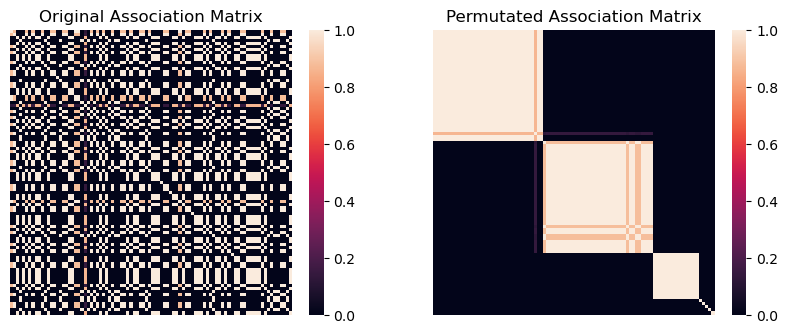

In [45]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3.7))

sns.heatmap(A_asso2, xticklabels = 0, yticklabels = 0, ax = axes[0])
axes[0].set_title('Original Association Matrix')

sns.heatmap(A_perm_asso2, xticklabels = 0, yticklabels = 0, ax = axes[1])
axes[1].set_title('Permutated Association Matrix')

Text(0.5, 1.0, 'nMI matrix')

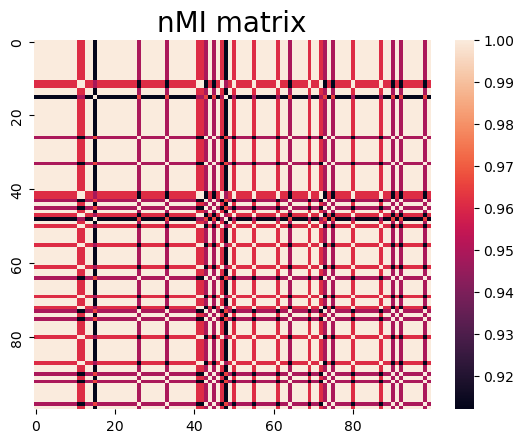

In [49]:
sns.heatmap(nMI_matrix2, xticklabels = 20, yticklabels = 20)
plt.title('nMI matrix', fontsize = 20)

# Questions

1. **Data Processing**: Change the network construction such that every snapshot contains 3 days of data and different snapshots overlap by 1 day. So snapshot 1 contains data from days 1, 2 and 3. Snapshot 2 contains data from days 2, 3, 4. etc.

2. **Temporal Analysis**:

    - Apply the code to each temporal snapshot and visualize the communities using seaborn.
    - Using a (or a few) measure(s) of partition similarity, quantify how much partitions change across different snapshots. (Note: You will see a way to visualize for this in the next support session.)

3. **Resolution Parameter**: Change the value of the resolution parameter in community detection and interpret the results.

4. **Statistical Significance**: How might you check whether the obtained communities are statistically significant?

5. **Directed Graph**: You might want to check if this community detection method can be performed on directed graphs. As previously mentioned, it is expected that this method is applicable to directed graphs.   

6. **Other Community Dection Methods**: There are other community detection methods besides modularity maximisation. For instance, Infomap is a flow-based community detection method that has been extensively researched and documented, and is also suitable for both directed and undirected, as well as weighted and unweighted graphs. Further details are available [here](https://www.mapequation.org/infomap/). Try to download the package and experiment with it.
    
    In fact, some of the functions we document for modularity maximisation may also be used for other community detection methods, such as "Result Visualisation through the Permutated Adjacency Matrix" and "Robustness Assessment - Association Matrix & nMI Matrix".

